In [8]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw
from bw2data import parameters
from lca_algebraic import findTechAct
from sympy.physics.units import years
from sympy.stats.crv_types import LogNormalDistribution
from sympy import init_printing
import lca_algebraic as agb
from dotenv import load_dotenv

# Custom utils defined for the parameterization
from lca_algebraic import *
from lca_algebraic.stats import *

# Pretty print for Sympy
init_printing()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, expon, beta, uniform, triang, kstest

In [10]:
BW_PROJECT = 'lca-alg-2' # insert your project name here
bd.projects.set_current(BW_PROJECT)
EI_DB = 'ecoinvent-3.9.1-cutoff' # name of ecoinvent database in your project
# We use a separate DB for defining our foreground model / activities
USER_DB = "MyForeground"

In [11]:
EI_Database = bw.Database("ecoinvent-3.9.1-cutoff")

In [12]:
# This is better to cleanup the whole foreground model each time, and redefine it in the notebook (or a python file)
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
agb.resetDb(USER_DB)

# Parameters are stored at project level : 
# Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
agb.resetParams()

# Overview of the databases
agb.list_databases()

[WARNING] Db MyForeground was here. Reseting it


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,0,foreground


# A few details on lca-algebraic

## Search for activities

* Activities related to biosphere with biosphere with `agb.findBioAct`
* Activities related to biosphere with technosphere with `agb.findTechAct`
* Activities with `agb.findActivity`

## Distribution types

**lca_algebraic** supports seven distribution types: 
- Fixed, not considered as a variable input for MC simulation
- Uniform distribution between min and max
- Triangle distribution between min and max (set to zero probability), with highest probability at default value
- Normal distribution, centered on default value (mean), with deviation of std and truncated between min and max
- Log-normal distribution, centered on default value (mean), with deviation of std, not truncated
- Beta distribution with extra params a and b, using default value as ‘loc’ (0 of beta distribution) and std as ‘scale’ (1 of beta distribution)
- Statistic weight

## Parameters types

**lca_algebraic** can define 3 types of parameters :
* Float parameter, with `newFloatParam(...)`. The user should provide its name, unit and statistical distribution.
* Bool parameter (e.g. 0 or 1), with `newBoolParam(...)`
* Enum parameter which represent a set of mutually exclusive choices, that corresponds to the definition of several boolean parameters with newEnumParam(...) > for example, for an electricity mix, we have to choose one mix among others
|


## Create, modify or switch activities

* Create a new activity with `agb.newActivity()`
* Copy and modified an activity with `agb.copyActivity()`
    * Change the value of a flow (with another number of mathematic formula) with `.updateExchanges`() 
    * Change a flow by another flow with `.updateExchanges`()
    * Add a new flow with `.addExchanges`()
    * Delete an existing flow with `.updateExchanges`()
* Switch activity with `newSwitchAct`(), acting like a switch between several possibilities

# Identify LCI of interests in EI

After identifying the LCI of our choice, we need to make a copy to preserve the non-parametrized inventories

In [13]:
# Don't know why it finds 2 activities
cu_mining_benef = findActivity('copper mine operation and beneficiation, sulfide ore', loc='CA', db_name=EI_DB,
                               single=False)

In [14]:
cu_mining = [act for act in EI_Database 
             if act["name"] == 'copper mine operation and beneficiation, sulfide ore' 
             and act['location'] == 'CA'][0]

In [15]:
cu_mining_p = agb.copyActivity(
    db_name=USER_DB,                            # Database where the new activity is copied
    activity = cu_mining,                  # initial activity
    code = "copper mine operation and beneficiation, sulfide ore, parametrized") 

In [ ]:
mine_open_cast = mine construction, open cast, non-ferrous metal GLO
mine_underground = 

# Defining input parameters for the parametrization

## Copper

In [16]:
# From Ore grade notebooks
cu_mean = 0.834055
cu_min = 0.004
cu_max = 7.92
cu_std = 0.907797

In [17]:
og_cu_world = newFloatParam(
    'ore_grade_copper', 
    default=cu_mean,
    std= cu_std,
    min=cu_min,
    max=cu_max,
    unit='dimensionless',
    distrib=DistributionType.NORMAL,
    description="From statistical analysis of ore grade data from Mudd et al (2018)",
    label="Copper ore grade",
    dbname=USER_DB, 
    save=False #By default, new parameters are kept in memory but also persisted in the project (unless save=False)
)

In [18]:
#If you print an lca_algebraic parameter, its name is printed but not its value
og_cu_world

In [19]:
#Print the name, default value and unit of one parameter
(og_cu_world.name, og_cu_world.default, og_cu_world.unit)

('ore_grade_copper', 0.834055, 'dimensionless')

In [20]:
mining_depth_cu = newFloatParam(
    'mining_depth_copper', 
    default=cu_mean,
    std= cu_std,
    min=cu_min,
    max=cu_max,
    unit='dimensionless',
    distrib=DistributionType.NORMAL,
    description="mining depth copper",
    label="Mining depth copper",
    dbname=USER_DB, 
    save=False #By default, new parameters are kept in memory but also persisted in the project (unless save=False)
)

In [21]:
mining_technique_mix = {'open_pit':0.8,
                'underground':0.2}

In [22]:
mining_energy_mix = {'diesel':0.3,
                        'electricity':0.7}

In [24]:
mining_electricity_switch = newEnumParam(
    'mining_electricity_switch', 
    label='Mining electricity, grid or diesel',
    values=['dieselgenerator',
            'grid'], # You can provide a statistical weight for each value, by using a dict
    default='dieselgenerator', 
    description="Choice of electricity source for mining",
    dbname=USER_DB)

In [32]:
diesel_generator = findActivity('market for diesel', loc='RoW', db_name=EI_DB)
elec_grid        = findActivity('market group for electricity, high voltage', loc='CA', db_name=EI_DB)

# Update exchanges by their name 
mining_elec_mix = newSwitchAct(USER_DB, 
    'mining_elec_mix', # Name
    mining_electricity_switch, # Switch parameter
    { # Dictionary of enum values / activities
        'dieselgenerator' : diesel_generator, # in MJ
        'grid' : (elec_grid, 1/3.6)  # in MJ (convert from kWh)
    })

In [33]:
mining_elec_mix

'mining_elec_mix' (kilowatt hour, GLO, None)

In [41]:
elec_mix_country=agb.newEnumParam( 
    "elec_mix_country",                     # Short name
    label="electrical mix",        # label
    description="region chosen for the electricity mix", # Long description  
    group="mining",          # (optional) to class your parameters in group
    values =[                       # Statistic weight of each option that fits with the market
        "Alberta",
        "Quebec"
    ],
    default="Quebec",
    dbname=USER_DB) 

In [42]:
alberta_elec_mix=agb.findTechAct('market for electricity, high voltage','CA-AB')
quebec_elec_mix=agb.findTechAct('market for electricity, high voltage','CA-QC')

elec_mix = agb.newSwitchAct(
                    USER_DB, # Database where the new activity is created
                    "electricity mix",                                      
                    elec_mix_country, #enum parameter that is used to switch the activity
                            {
                                "Alberta":alberta_elec_mix,
                                "Quebec": quebec_elec_mix,
                            })

[WARNING] Activity 'electricity mix' was already in 'MyForeground'. Overwriting it


In [43]:
elec_mix

'electricity mix' (kilowatt hour, GLO, None)

## Nickel

In [44]:
# From ore grade notebook
ni_mean = 0.934864
ni_min = 0.015
ni_max = 3.99003
ni_std = 0.842238

In [45]:
og_ni_world = newFloatParam(
    'ore_grade_nickel', 
    default=ni_mean,
    std= ni_std,
    min=ni_min,
    max=ni_max,
    unit='dimensionless',
    distrib=DistributionType.NORMAL,
    description="From statistical analysis of ore grade data from Mudd et al (2014)",
    label="Nickel ore grade",
    dbname=USER_DB, 
    save=False #By default, new parameters are kept in memory but also persisted in the project (unless save=False)
)

[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.


In [46]:
list_parameters() # recap of all parameters declared in the model 

group,name,label,default,min,max,std,distrib,unit,db
,mining_depth_copper,Mining depth copper,0.834055,0.004,7.92,0.907797,normal,dimensionless,MyForeground
,mining_electricity_switch,"Mining electricity, grid or diesel",dieselgenerator,,,,,,MyForeground
,ore_grade_copper,Copper ore grade,0.834055,0.004,7.92,0.907797,normal,dimensionless,MyForeground
,ore_grade_nickel,Nickel ore grade,0.934864,0.015,3.99003,0.842238,normal,dimensionless,MyForeground
mining,elec_mix_country,electrical mix,Quebec,,,,,,[project]
mining,elec_mix_country,electrical mix,Quebec,,,,,,MyForeground


# Transforming and updating parametrized inventories

In [47]:
# From Van der Voelt (2019), who source it from Valero et al. (2011); Norgate and Jahanshahi (2006) Northey et al. (2014)
r_cu = 15.63
q_cu = -0.53

r_zinc = 77.65 
q_zinc = -1

r_pb = 75.42
q_pb = -1

r_ni_sulfide = 198.22
q_ni_sulfide = -0.406

r_ni_sulfide = 194.9
q_ni_sulfide = -0.494

In [48]:
# Update selected technosphere flow, it is the product name
cu_mining_p.updateExchanges({
    "electricity, high voltage": r_cu * np.power(og_cu_world, q_cu) # value or a mathematical formula, see energy_ore_grade function 
    
    #"diesel": 
    
    
})

In [51]:
cu_mining_p.updateExchanges({
    # This is electricity
    'electricity, medium voltage': dict(amount=mining_energy_mix['electricity'] * 2,
                                                                              input=mining_energy_mix),
    # This is diesel used as fuel
    'diesel': mining_energy_mix['diesel'] * 3
}
)

ValueError: Provided input data is invalid

In [52]:
# Test add exchanges 
steel = agb.findTechAct('market for steel, low-alloyed, hot rolled')
cu_mining_p.addExchanges({
steel: 7.25*0.2 
}
)

In [55]:
# To compare between the initial and parametrized inventory
agb.printAct(cu_mining, cu_mining_p)

# Impact calculation

In [29]:
[m for m in bw.methods if "IPCC 2021" in str(m)]

[('IPCC 2021 no LT',
  'climate change no LT',
  'global temperature change potential (GTP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global temperature change potential (GTP50) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP20) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP500) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global temperature change potential (GTP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global temperature change potential (GTP50) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP20) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global warming potentia

In [30]:
method_name = ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
gwp100 = [method for method in bw.methods if method == method_name]

In [31]:
agb.list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,2,foreground


In [1]:
agb.compute_impacts(

    models=[cu_mining, cu_mining_p],    # you can put multiple ones in list eg [act, act2]
    # list of impacts to consider
    methods=gwp100, 
    # The impacts will be divided by the functional unit
    functional_unit=1, # can be parametrized
    elec_mix_country='Quebec',
    return_params=True,     
    # Parameters of the model
    #ore_grade_copper = 0.95
    
)

NameError: name 'agb' is not defined

In [33]:
# Need to updgrade to 1.2
agb.exploreImpacts(
    gwp100,                  #impact category 
    methods=gwp100                   #name of the activity
    )

AttributeError: module 'lca_algebraic' has no attribute 'exploreImpacts'

## OAT sensitivity analysis

[INFO] Db changed recently, clearing cache expr


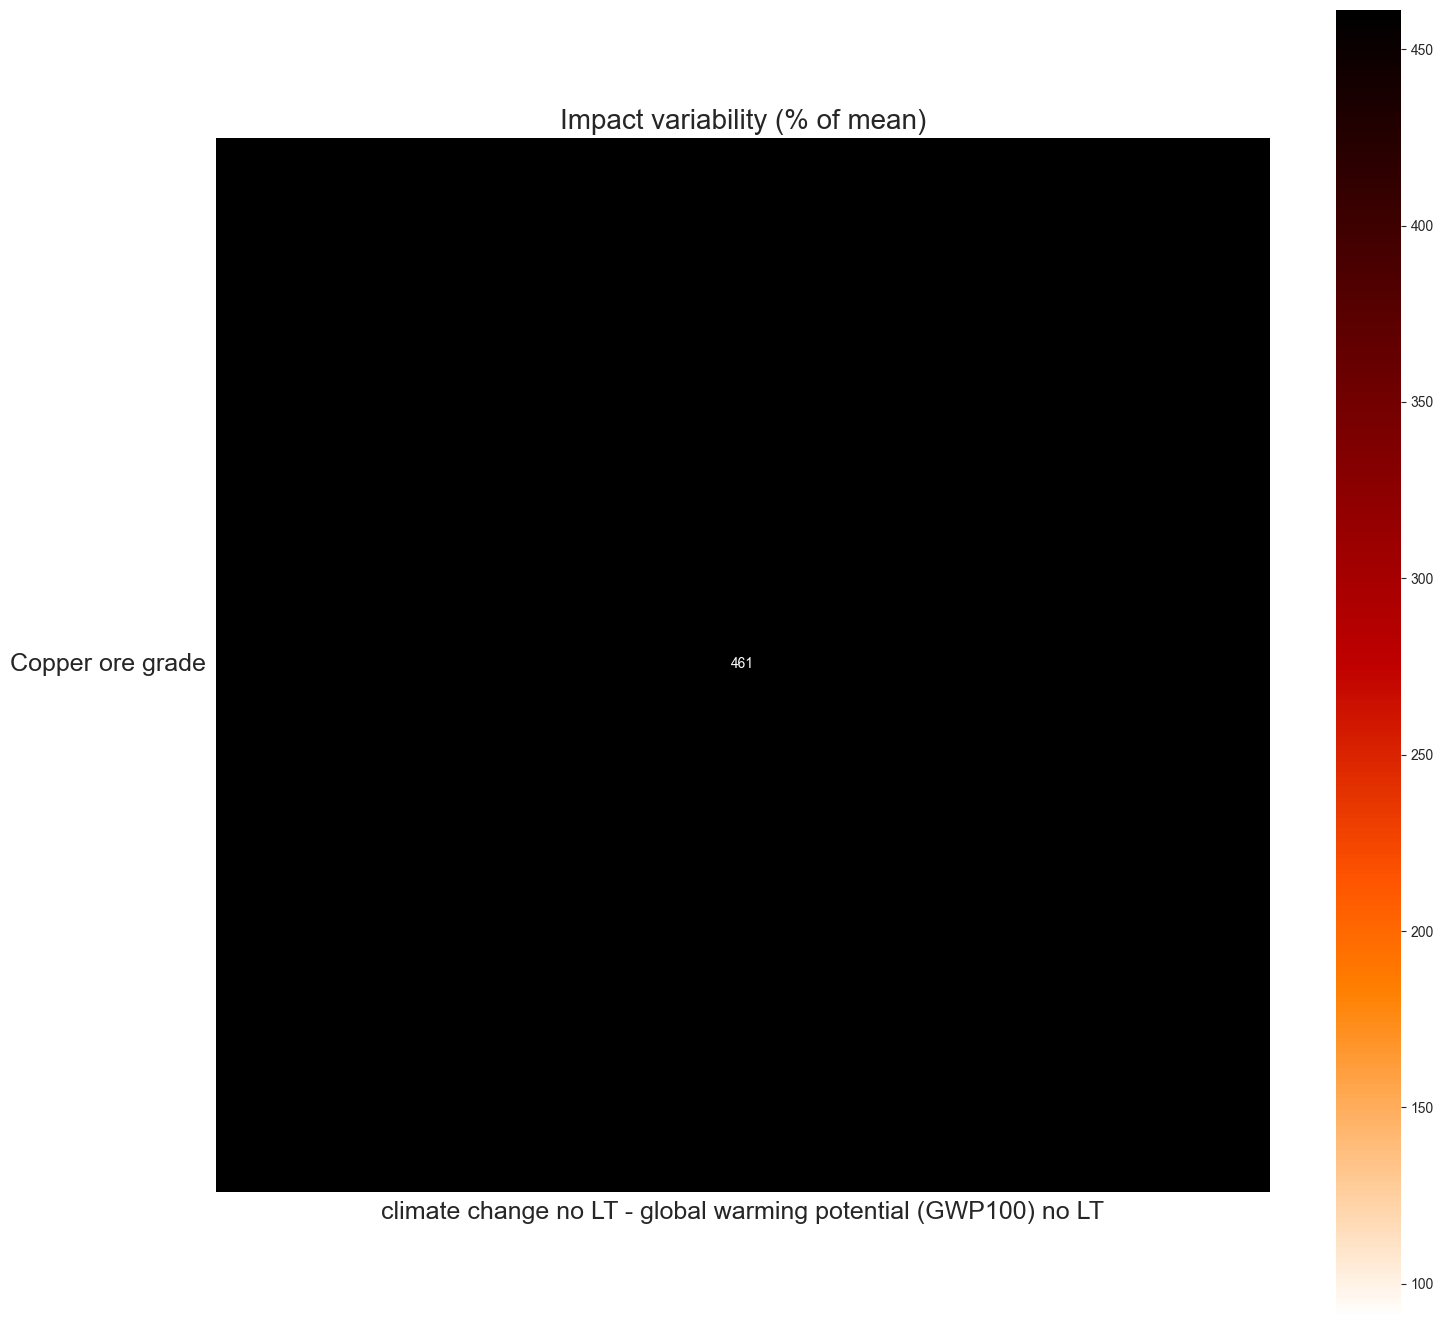

In [36]:
agb.oat_matrix(
    cu_mining_p, 
    gwp100, 
    functional_unit=1
)

In [136]:
agb.oat_dashboard(
    cu_mining_p, 
    gwp100, 
    functional_unit=1,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('ore_grade_copper',), value='ore_grade_copper'), …

## GSA

In [137]:
# Show sobol indices 
agb.incer_stochastic_matrix(
    cu_mining_copy, 
    gwp100, 
    functional_unit=1)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

Generating samples ...
Transforming samples ...


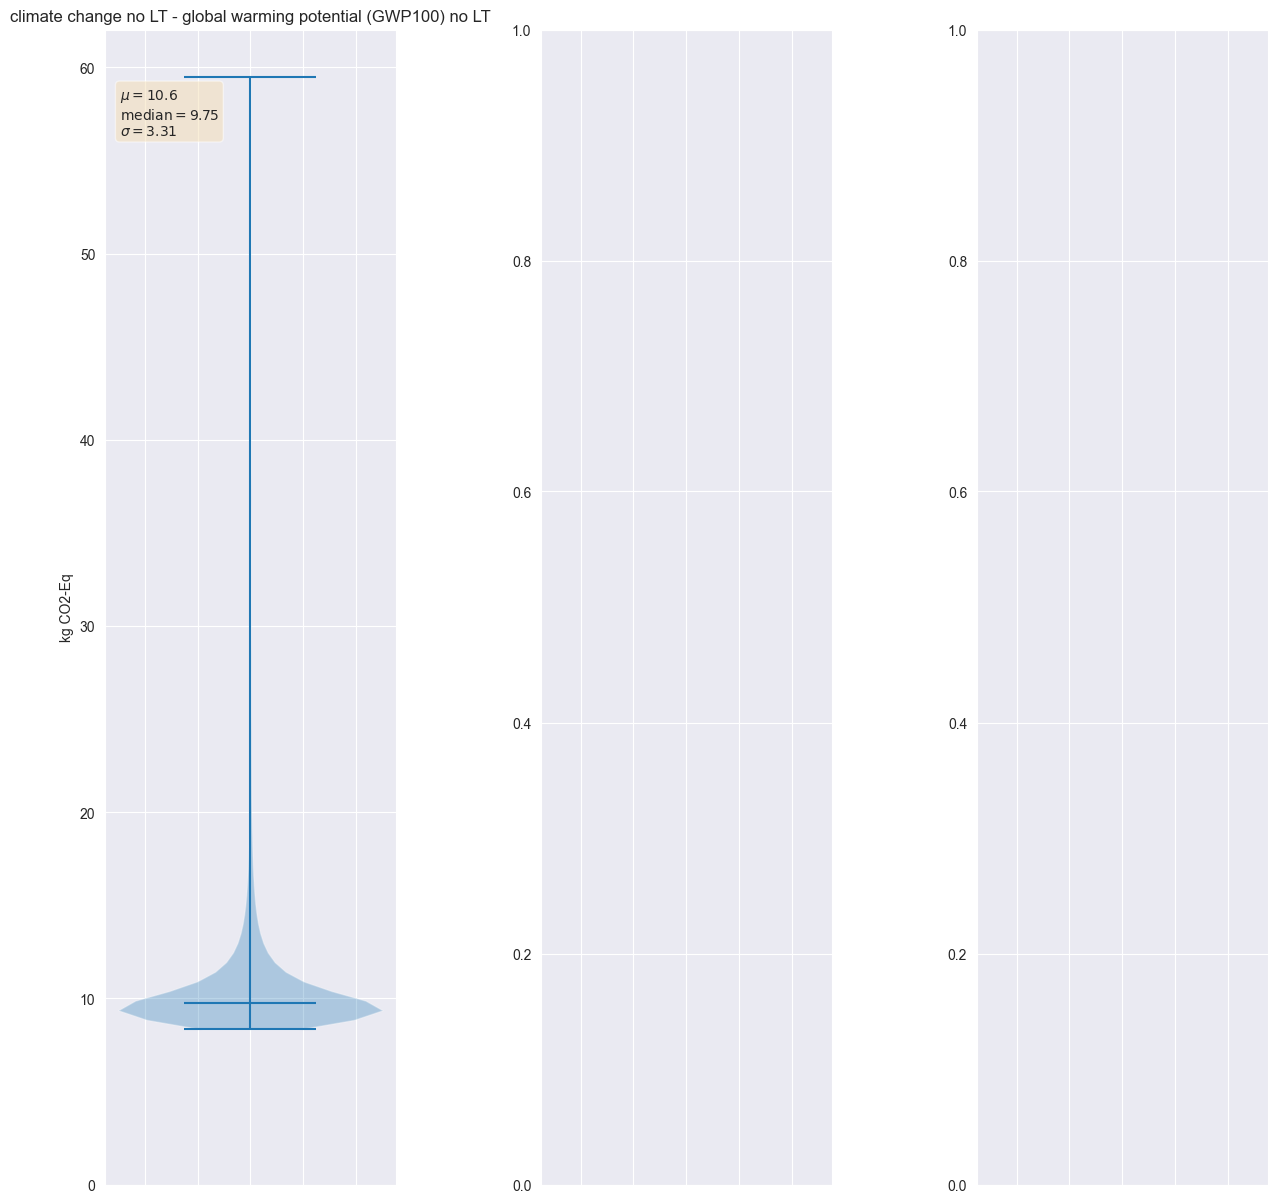

In [138]:
agb.incer_stochastic_violin(
    cu_mining_copy, gwp100,
    functional_unit=1,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...
Transforming samples ...


,climate change no LT - global warming potential (GWP100) no LT [kg CO2-Eq / ]
median,9.74497
std,3.28935
p,"[8.722027978618767, 15.235918233809436]"
mean,10.6431
var,0.30906


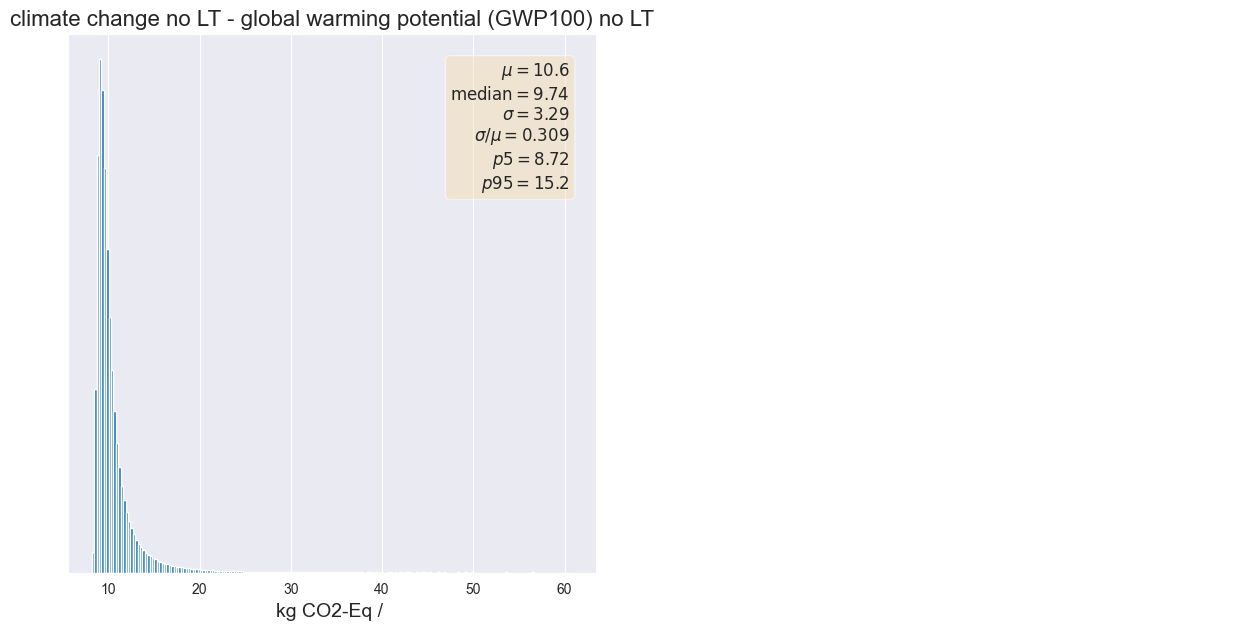

In [139]:
# Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
agb.distrib(
    cu_mining_copy, gwp100,
    functional_unit=1,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

In [140]:
# Full dashboard, including total variation of impacts 
agb.incer_stochastic_dashboard(
    model=cu_mining_copy, 
    methods=gwp100,
    functional_unit=1)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


# Simplified model

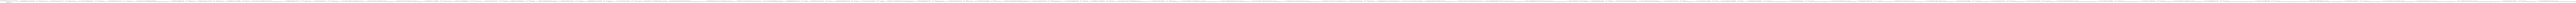

In [141]:
# First, let's look at the full expression defining our model
expr, _ = agb.actToExpression(cu_mining_copy)
expr

Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


> Method :  climate change no LT - global warming potential (GWP100) no LT
S1:  0.9978569033701155
S2:  0.0016207311406579716
ST:  0.99826208615528
Selected params :  ['ore_grade_copper'] explains:  0.9978569033701155


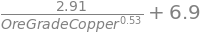

In [142]:
simplified = agb.sobol_simplify_model(
    cu_mining_copy, # The model
    gwp100, # Impacts to consider
    functional_unit=1,
    
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = agb.FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain
    num_digits=3)

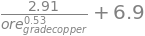

In [143]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055
[INFO] Required param 'ore_grade_copper' was missing, replacing by default value : 0.834055


Generating samples ...
Transforming samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


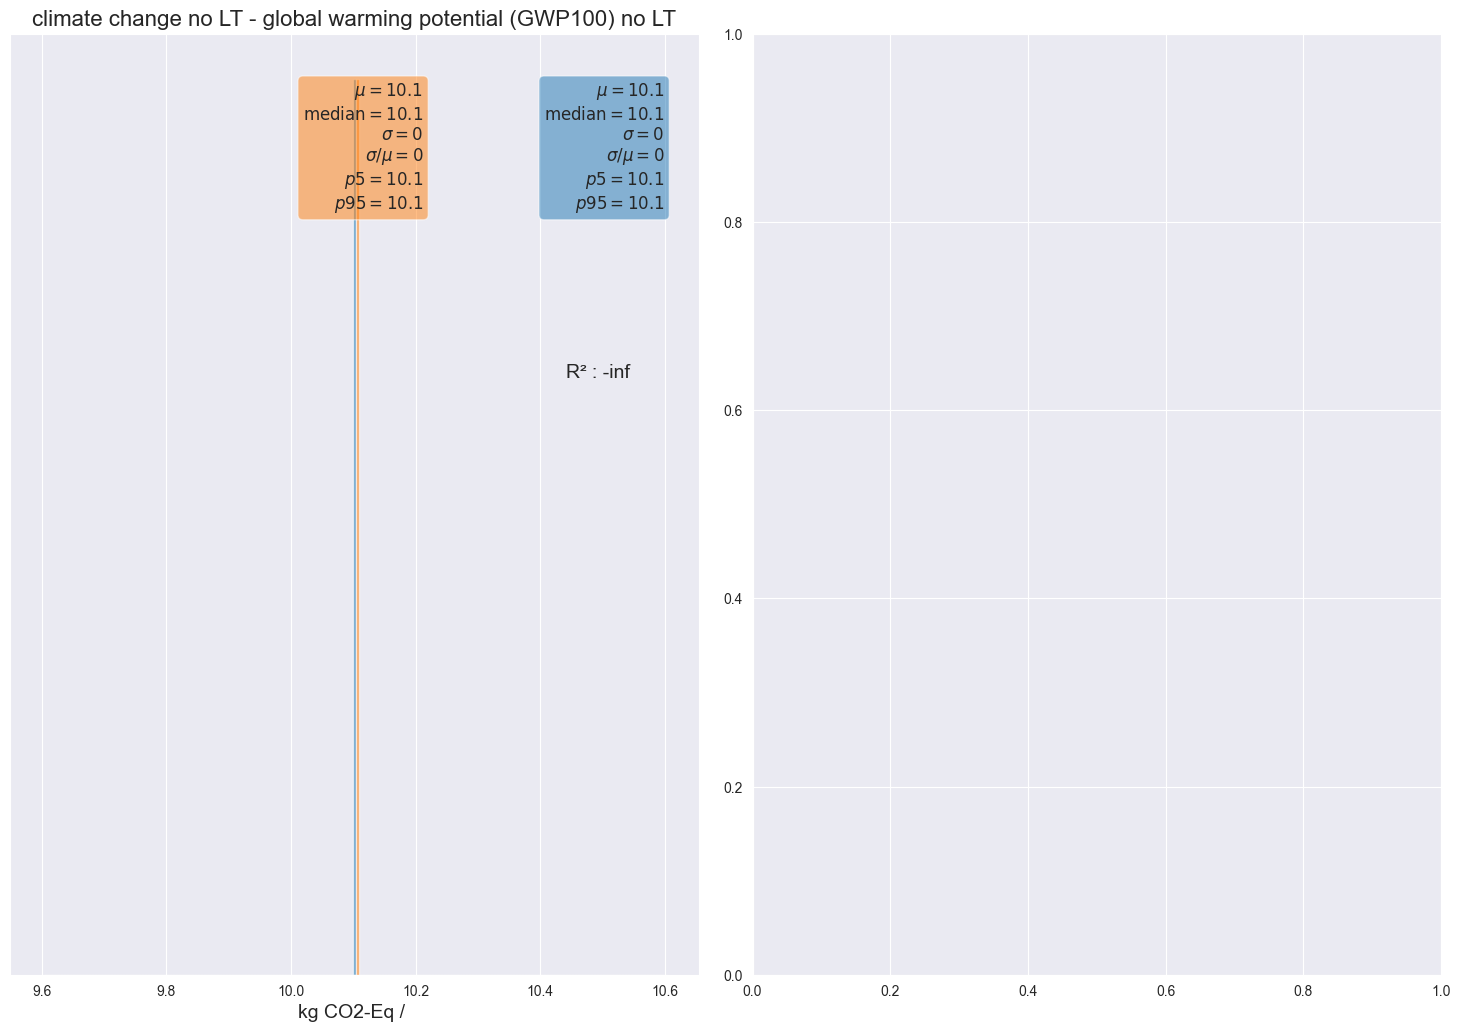

In [144]:
agb.compare_simplified(
    cu_mining_copy, 
    gwp100, 
    simplified,
    functional_unit=1)